In [436]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd

import time

import jax
import jax.numpy as jnp
from jax import random
import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC
from numpyro.infer import SVI, Trace_ELBO, Predictive
import numpyro.diagnostics

from termcolor import colored
import matplotlib.pyplot as plt

from pathlib import Path

import dill
import pickle
import arviz as az

from sklearn.preprocessing import QuantileTransformer

# GP Kernel Function

In [437]:
def dist_euclid(x, z):
    """
    Computes Eucledian Distance Between Regions. This function is used by
    exp_sq_kernel function (kernel function for gaussian processes)
    """
    x = jnp.array(x) # (ngrid_pts, lat/lon) <- i.e (7304,2)
    z = jnp.array(z) # (ngrid_pts, lat/lon) <- i.e (7304,2)
    if len(x.shape)==1:
        x = x.reshape(x.shape[0], 1) #(2618,) -> (7304,1)
    if len(z.shape)==1:
        z = x.reshape(x.shape[0], 1) #(2618,) -> (7304,1)
    n_x, m = x.shape # 7304 , 2
    n_z, m_z = z.shape # 7304 , 2
    assert m == m_z
    delta = jnp.zeros((n_x,n_z)) #(ngrid_pts,ngrid_pts) <- i.e (7304,7304)
    for d in jnp.arange(m):
        x_d = x[:,d] #(ngrid_pts-lat/lon,) <- (7304,)
        z_d = z[:,d] #(ngrid_pts-lat/lon,) <- (7304,)
        delta += (x_d[:,jnp.newaxis] - z_d)**2 # (7304,7304)

    return jnp.sqrt(delta) #(7304,7304)

In [438]:
def exp_sq_kernel(x, z, var, length, noise, jitter=1.0e-4):
    dist = dist_euclid(x, z) #(7304, 7304)
    deltaXsq = jnp.power(dist/ length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    k += (noise + jitter) * jnp.eye(x.shape[0])
    return k # (ngrid_pts, ngrid_pts) <- (7304,7304)


# Aggregation Functions

In [439]:
def M_g(M, g):
    '''
    - $M$ is a matrix with binary entries $m_{ij},$ showing whether point $j$ is in polygon $i$
    - $g$ is a vector of GP draws over grid
    - $maltmul(M, g)$ gives a vector of sums over each polygon
    '''
    M = jnp.array(M)
    g = jnp.array(g).T
    return(jnp.matmul(M, g))

# Aggregated Prevalence Model - must edit this to include HDI, population density



In [440]:
def prev_model_gp_aggr(args):
    """Dengue prevalence model with a Gaussian Process"""

    x = args["x"]  # Spatial grid points: (num_grid_points, 2)
    gp_kernel = args["gp_kernel"]  # Gaussian Process kernel
    noise = args["noise"]
    jitter = args["jitter"]

    #covariates
    pop_density = args["pop_density"]
    hdi = args["hdi"]
    urban = args['urban']

    M_lo = args["M_lo"]  # (4, num_grid_points) aggregation matrix
    M_hi = args["M_hi"]  # (24, num_grid_points) aggregation matrix

    total_cases_lo = args["total_cases_lo"] #cos we wanna predict total cases district-wise, so only feed total cases for low res data

    total_population_lo = args["total_population_lo"]
    total_population_hi = args["total_population_hi"]

    #aggregate total populations low and high
    total_population = jnp.concatenate([total_population_lo,total_population_hi], axis = 0)

    #add NaN values to total_cases to accommodate for unavailable total cases data for high resolution (that we want to predict)
    total_cases = jnp.pad(total_cases_lo, (0, M_hi.shape[0]),constant_values = 0.0) #[3762.  484. ... , 0,0,0]
    total_cases = jnp.where(total_cases == 0, jnp.nan, total_cases)# [3762.  484. ... , nan,nan,nan]
    total_cases_mask = ~jnp.isnan(total_cases) # [True, True, ...., False, False, False]

    # GP hyperparameters
    kernel_length = numpyro.sample("kernel_length", args["kernel_length"])
    kernel_var = numpyro.sample("kernel_var", args["kernel_var"])

    # GP Kernel and Sample
    k = gp_kernel(x, x, kernel_var, kernel_length, noise, jitter)
    f = numpyro.sample("f", dist.MultivariateNormal(loc=jnp.zeros(x.shape[0]), covariance_matrix=k))  # (num_grid_points,)

    # Aggregate GP values to district level
    gp_aggr_lo = numpyro.deterministic("gp_aggr_lo", M_g(M_lo, f))  # (4,)
    gp_aggr_hi = numpyro.deterministic("gp_aggr_hi", M_g(M_hi, f))  # (24,)

    # Now we need to aggregate both. This step is important since even though we only
    # show the model the low resolution data, to produce high resolution data it
    # needs th GP realizations for those regions
    gp_aggr = numpyro.deterministic("gp_aggr", jnp.concatenate([gp_aggr_lo,gp_aggr_hi])) #(28,)

    # Fixed effects
    b0 = numpyro.sample("b0", dist.Normal(0, 1))  # Intercept
    b_pop_density = numpyro.sample("b_pop_density", dist.Normal(0, 1))  # Effect of population density
    b_hdi = numpyro.sample("b_hdi", dist.Normal(0, 1))  # Effect of HDI
    b_urban = numpyro.sample("b_urban", dist.Normal(0, 1))  # Effect of urbanicity

    #standardise all the vars
    pop_density = (pop_density - jnp.mean(pop_density)) / jnp.std(pop_density)
    hdi = (hdi - jnp.mean(hdi)) / jnp.std(hdi)
    urban = (urban - jnp.mean(urban)) / jnp.std(urban)

    # Linear predictor
    lp = b0 + gp_aggr + b_pop_density * pop_density + b_hdi * hdi + b_urban * urban  # (num_districts,)

    # Prevalence probability
    theta = numpyro.deterministic("theta", jax.nn.sigmoid(lp) * 2e-3)  # (num_districts,)

    # Binomial likelihood
    with numpyro.handlers.mask(mask=total_cases_mask):
        observed_cases = numpyro.sample(
            "observed_cases",
            dist.Binomial(total_count=total_population, probs=theta),
            obs=total_cases)

    return observed_cases


# Load Data

In [441]:
# Lat/Lon Values of artificial grid
x = np.load("../data/lat_lon_x_jkt.npy")

# combined regional data
pol_pts_jkt_lo = np.load("../data/pol_pts_jkt_lo.npy")
pt_which_pol_jkt_lo = np.load("../data/pt_which_pol_jkt_lo.npy")
pol_pts_jkt_hi = np.load("../data/pol_pts_jkt_hi.npy")
pt_which_pol_jkt_hi = np.load("../data/pt_which_pol_jkt_hi.npy")

#combine the dataframes
df_lo = gpd.read_file("../data/jkt_prov.shp")
df_hi = gpd.read_file("../data/jkt_dist.shp")

# Vars needed to be changed (change according to the agg prevalence model parameters)

In [442]:
M_lo = jnp.array(pol_pts_jkt_lo)
M_hi = jnp.array(pol_pts_jkt_hi)
cases_lo = jnp.array(df_lo["Cases"])
pop_lo = jnp.array(df_lo["Population"])
pop_hi = jnp.array(df_hi["Population"])

In [443]:
#print the shape of all the vars above
print(M_lo.shape)
print(M_hi.shape)
print(cases_lo.shape)
print(pop_lo.shape)
print(pop_hi.shape)
print(x.shape)

(4, 100)
(20, 100)
(4,)
(4,)
(20,)
(100, 2)


# Agg GP Model

In [444]:
# Step 1: Convert everything to numpy arrays first (if they're not already)
pop_lo = np.array(df_lo["Pop_den"]).reshape(-1, 1)
pop_hi = np.array(df_hi["Pop_den"]).reshape(-1, 1)
hdi_lo = np.array(df_lo["HDI"]).reshape(-1, 1)
hdi_hi = np.array(df_hi["HDI"]).reshape(-1, 1)
urban_lo = np.array(df_lo["urbanicity"]).reshape(-1, 1)
urban_hi = np.array(df_hi["urbanicity"]).reshape(-1, 1)

# Step 2: Concatenate low and high resolution data
pop_all = np.concatenate([pop_lo, pop_hi], axis=0)
hdi_all = np.concatenate([hdi_lo, hdi_hi], axis=0)
urban_all = np.concatenate([urban_lo, urban_hi], axis=0)

# Step 3: Apply QuantileTransformer on full vector (low + high)
qt = QuantileTransformer(output_distribution='normal', random_state=42)

pop_all_qt = qt.fit_transform(pop_all).squeeze()  # shape (28,)
hdi_all_qt = qt.fit_transform(hdi_all).squeeze()
urban_all_qt = qt.fit_transform(urban_all).squeeze()

pop_lo = np.array(df_lo["Pop_den"]).reshape(-1, 1)
pop_hi = np.array(df_hi["Pop_den"]).reshape(-1, 1)
hdi_lo = np.array(df_lo["HDI"]).reshape(-1, 1)
hdi_hi = np.array(df_hi["HDI"]).reshape(-1, 1)
urban_lo = np.array(df_lo["urbanicity"]).reshape(-1, 1)
urban_hi = np.array(df_hi["urbanicity"]).reshape(-1, 1)

pop_all = np.concatenate([pop_lo, pop_hi], axis=0)
hdi_all = np.concatenate([hdi_lo, hdi_hi], axis=0)
urban_all = np.concatenate([urban_lo, urban_hi], axis=0)

C:\Users\jessi\AppData\Roaming\Python\Python313\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (24). n_quantiles is set to n_samples.
  warnings.warn(
C:\Users\jessi\AppData\Roaming\Python\Python313\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (24). n_quantiles is set to n_samples.
  warnings.warn(
C:\Users\jessi\AppData\Roaming\Python\Python313\site-packages\sklearn\preprocessing\_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (24). n_quantiles is set to n_samples.
  warnings.warn(


In [445]:
args = {
        "x" : jnp.array(x), # Lat/lon vals of grid points # Shape (num_districts, 2)
        "gp_kernel" : exp_sq_kernel,
        "jitter" : 1e-4,
        "noise" : 1e-4,
        "M_lo" : M_lo, # Aggregation matrix # Shape (num_districts, num_districts)
        "M_hi" : M_hi, # Aggregation matrix # Shape (num_districts, num_districts)
        # GP Kernel Hyperparams
        "kernel_length" : dist.InverseGamma(3, 3), #(,)
        "kernel_var" : dist.HalfNormal(1e-5),
        "pop_density_qt": jnp.array(pop_all_qt), # Shape (num_districts,)
        "hdi_qt": jnp.array(hdi_all_qt), # Shape (num_districts, 2)
        "urban_qt": jnp.array(urban_all_qt),
        "pop_density": jnp.array(pop_all), # Shape (num_districts,)
        "hdi": jnp.array(hdi_all), # Shape (num_districts, 2)
        "urban": jnp.array(urban_all),
        "total_cases_lo" : cases_lo,
        "total_population_lo" : pop_lo,
        "total_population_hi" : pop_hi
}


# Run MCMC

In [446]:
# Base seed for reproducibility
base_seed = 3  # Keep this fixed for full replicability


# MCMC settings
n_warm = 1000
n_samples = 2000

In [447]:
save_dir = Path.cwd().parent / "model weights" / "aggGP"

# Save Model

In [448]:
# Run MCMC with 1 chain at a time

for chain_id in range(4):
    print(f"Starting Chain {chain_id+1}/4...")

    # Generate a unique but reproducible key for each chain
    chain_key = jax.random.fold_in(jax.random.PRNGKey(base_seed), chain_id)

    mcmc = MCMC(
        NUTS(prev_model_gp_aggr),
        num_warmup=n_warm,
        num_samples=n_samples,
        num_chains=1  # Run one chain at a time
    )

    start = time.time()
    try:
        mcmc.run(chain_key, args)  # Use the fixed but different seed for each chain
        end = time.time()
        t_elapsed = end - start
        print(t_elapsed)
        t_elapsed_min = round((end - start) / 60)

        # Save after each successful chain
        f_path = f"{save_dir}/aggGP_chain{chain_id+1}_nsamples_{n_samples}_tt{t_elapsed_min}min.pkl"
        with open(f_path, "wb") as file:
            dill.dump(mcmc, file)

        print(f"Saved Chain {chain_id+1} to {f_path}")

    except Exception as e:
        print(f"Error occurred in Chain {chain_id+1}: {e}")
        break  # Stop if an error occurs

Starting Chain 1/4...


sample: 100%|██████████| 3000/3000 [00:18<00:00, 160.93it/s, 15 steps of size 2.77e-01. acc. prob=0.89]


18.766631364822388
Saved Chain 1 to c:\Users\jessi\Documents\school\y4\s2\DSE4101\Individual\FYP codes\DSE_FYP\simulation study\model weights\aggGP/aggGP_chain1_nsamples_2000_tt0min.pkl
Starting Chain 2/4...


sample: 100%|██████████| 3000/3000 [00:26<00:00, 114.93it/s, 15 steps of size 2.89e-01. acc. prob=0.90]


26.262633323669434
Saved Chain 2 to c:\Users\jessi\Documents\school\y4\s2\DSE4101\Individual\FYP codes\DSE_FYP\simulation study\model weights\aggGP/aggGP_chain2_nsamples_2000_tt0min.pkl
Starting Chain 3/4...


sample: 100%|██████████| 3000/3000 [00:24<00:00, 124.47it/s, 15 steps of size 2.82e-01. acc. prob=0.88]


24.239853620529175
Saved Chain 3 to c:\Users\jessi\Documents\school\y4\s2\DSE4101\Individual\FYP codes\DSE_FYP\simulation study\model weights\aggGP/aggGP_chain3_nsamples_2000_tt0min.pkl
Starting Chain 4/4...


sample: 100%|██████████| 3000/3000 [00:26<00:00, 114.85it/s, 15 steps of size 3.30e-01. acc. prob=0.87]

26.25592851638794
Saved Chain 4 to c:\Users\jessi\Documents\school\y4\s2\DSE4101\Individual\FYP codes\DSE_FYP\simulation study\model weights\aggGP/aggGP_chain4_nsamples_2000_tt0min.pkl


# Results Inference

In [449]:
# Directory where chains are saved (sibling to `src`)
model_weights_path = Path.cwd().parent / "model weights" / "aggGP"

print(f"Looking in: {model_weights_path}")

# Load all chains
all_samples = []
for chain_id in range(4):  # Assuming 4 chains were run
    file_prefix = f"aggGP_chain{chain_id+1}_nsamples_{n_samples}_tt"

    # Find all matching files
    matching_files = sorted([
        f.name for f in model_weights_path.iterdir()
        if f.name.startswith(file_prefix)
    ])

    if not matching_files:
        print(f"Warning: No file found for chain {chain_id+1}")
        continue

    # Load the most recent matching file
    latest_file = model_weights_path / matching_files[-1]
    with open(latest_file, "rb") as file:
        mcmc = dill.load(file)

    # Extract and store samples
    samples = mcmc.get_samples()
    all_samples.append(samples)
    print(f"Loaded chain {chain_id+1} from {latest_file.name}")

# Stack samples into (num_chains, num_samples, ...) format
if all_samples:
    samples_grouped = {
        k: jnp.stack([chain[k] for chain in all_samples], axis=0)
        for k in all_samples[0].keys()
    }
    print("Successfully grouped all chains for diagnostics.")
else:
    samples_grouped = None
    print("No chains loaded.")

Looking in: c:\Users\jessi\Documents\school\y4\s2\DSE4101\Individual\FYP codes\DSE_FYP\simulation study\model weights\aggGP
Loaded chain 1 from aggGP_chain1_nsamples_2000_tt0min.pkl
Loaded chain 2 from aggGP_chain2_nsamples_2000_tt0min.pkl
Loaded chain 3 from aggGP_chain3_nsamples_2000_tt0min.pkl
Loaded chain 4 from aggGP_chain4_nsamples_2000_tt0min.pkl
Successfully grouped all chains for diagnostics.


In [450]:
samples = samples_grouped

In [451]:
#view the theta
samples["theta"]

Array([[[[0.00199989, 0.00199989, 0.00199989, ..., 0.00199987,
          0.00199987, 0.00199987],
         [0.00199989, 0.00199989, 0.00199989, ..., 0.00199987,
          0.00199987, 0.00199987],
         [0.00199988, 0.00199988, 0.00199988, ..., 0.00199987,
          0.00199987, 0.00199987],
         ...,
         [0.00199988, 0.00199988, 0.00199988, ..., 0.00199986,
          0.00199986, 0.00199986],
         [0.00199991, 0.00199991, 0.00199991, ..., 0.0019999 ,
          0.0019999 , 0.0019999 ],
         [0.00199991, 0.00199991, 0.00199991, ..., 0.0019999 ,
          0.0019999 , 0.0019999 ]],

        [[0.0019999 , 0.0019999 , 0.0019999 , ..., 0.00199988,
          0.00199988, 0.00199988],
         [0.00199989, 0.00199989, 0.00199989, ..., 0.00199988,
          0.00199988, 0.00199988],
         [0.00199988, 0.00199988, 0.00199988, ..., 0.00199986,
          0.00199986, 0.00199986],
         ...,
         [0.00199989, 0.00199989, 0.00199989, ..., 0.00199987,
          0.00199987, 0.0

In [452]:
#assess the R hat, ESS etc.,
n_lo = df_lo.shape[0]
n_hi = df_hi.shape[0]

ss = numpyro.diagnostics.summary(samples_grouped)
r = np.mean(ss["gp_aggr"]["n_eff"])
print(f"Average ESS for all aggGP effects : {round(r)}")

ess_lo = np.mean(ss["gp_aggr"]["n_eff"][0:n_lo])
r_hat_lo = np.max(ss["gp_aggr"]["r_hat"][0:n_lo])

ess_hi = np.mean(ss["gp_aggr"]["n_eff"][n_lo:n_lo + n_hi])
r_hat_hi = np.max(ss["gp_aggr"]["r_hat"][n_lo : n_lo + n_hi])

print(f"Average ESS for all aggGP-low effects : {round(ess_lo)}")
print(f"Max r_hat for all aggGP-low : {round(r_hat_lo,2)}")

print(f"Average ESS for all aggGP-high effects : {round(ess_hi)}")
print(f"Max r_hat for all aggGP-high : {round(r_hat_hi,2)}")

print(f"kernel_length R-hat : {round(ss['kernel_length']['r_hat'], 2)}")
print(f"kernel_var R-hat : {round(ss['kernel_var']['r_hat'],2)}")

Average ESS for all aggGP effects : 894
Average ESS for all aggGP-low effects : 649
Max r_hat for all aggGP-low : 1.0099999904632568
Average ESS for all aggGP-high effects : 943
Max r_hat for all aggGP-high : 1.0099999904632568
kernel_length R-hat : 1.0
kernel_var R-hat : 1.0


In [453]:
# Convert summary stats to a DataFrame for better readability
df_summary = pd.DataFrame.from_dict(ss, orient="index")
print(df_summary)

                                                            mean  \
b0                                                      9.271475   
b_hdi                                                  -0.024476   
b_pop_density                                          -0.053218   
b_urban                                                 0.036851   
f              [0.0075076264, 0.00761658, 0.0073684044, 0.007...   
gp_aggr        [0.54685473, 0.54685473, 0.54685473, 0.5468547...   
gp_aggr_hi     [0.09651606, 0.09651606, 0.09651606, 0.0965160...   
gp_aggr_lo      [0.54685473, 0.54685473, 0.54685473, 0.54685473]   
kernel_length                                           1.474532   
kernel_var                                              0.000015   
theta          [[0.0019998583, 0.0019998583, 0.0019998583, 0....   

                                                             std  \
b0                                                      0.449497   
b_hdi                                          

array([[<Axes: title={'center': 'kernel_var'}>,
        <Axes: title={'center': 'kernel_var'}>]], dtype=object)

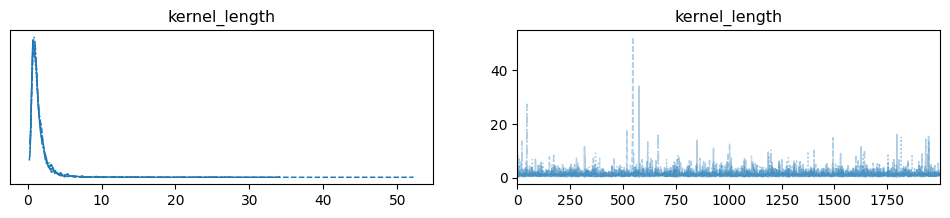

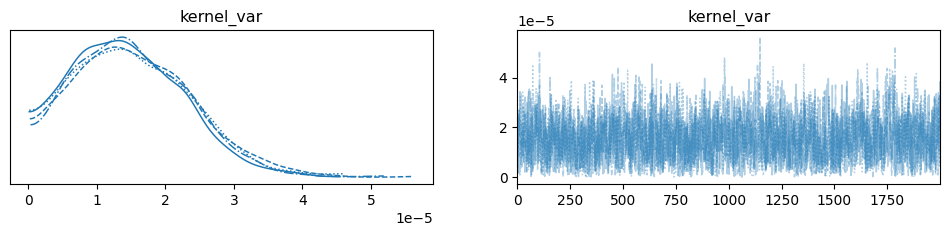

In [454]:
# Convert manually combined samples into an ArviZ InferenceData object
case_samples_az_gp = az.from_dict(posterior=samples_grouped)

# Plot trace plots for kernel_length and kernel_var
az.plot_trace(case_samples_az_gp, var_names=["kernel_length"])
az.plot_trace(case_samples_az_gp, var_names=["kernel_var"])

### Calculate and append observed and gp-estimated theta

In [455]:
samples["theta"].shape

(4, 2000, 24, 24)

In [456]:
theta_mean_gp = samples["theta"].mean(axis = (0, 1))
theta_mean_gp_scalar = theta_mean_gp.mean(axis=1)  # now shape: (n_obs,)

bci_gp_25 = np.quantile(samples["theta"],0.25,axis = (0, 1))
bci_gp_75 = np.quantile(samples["theta"],0.75, axis = (0, 1))

# Slice IQR values to match low-res and high-res
bci_lo_25 = bci_gp_25[:n_lo]
bci_lo_75 = bci_gp_75[:n_lo]

bci_hi_25 = bci_gp_25[n_lo:n_lo + n_hi]
bci_hi_75 = bci_gp_75[n_lo:n_lo + n_hi]


df_lo["obs_prev"] = df_lo["Cases"] / df_lo["Population"]
df_hi["obs_prev"] = df_hi["Cases"] / df_hi["Population"]

df_lo["theta_gp"] = theta_mean_gp_scalar[0:n_lo]
df_hi["theta_gp"] = theta_mean_gp_scalar[n_lo:n_lo + n_hi]

theta_obs_lo = df_lo["obs_prev"]
theta_gp_est_lo = df_lo["theta_gp"]
theta_obs_hi = df_hi["obs_prev"]
theta_gp_est_hi = df_hi["theta_gp"]

max_val_lo = np.max(np.concatenate([theta_obs_lo.values, theta_gp_est_lo.values]))
min_val_lo = np.min(np.concatenate([theta_obs_lo.values, theta_gp_est_lo.values]))

max_val_hi = np.max(np.concatenate([theta_obs_hi.values, theta_gp_est_hi.values]))
min_val_hi = np.min(np.concatenate([theta_obs_hi.values, theta_gp_est_hi.values]))

In [457]:
print(df_hi["theta_gp"])

0     0.002
1     0.002
2     0.002
3     0.002
4     0.002
5     0.002
6     0.002
7     0.002
8     0.002
9     0.002
10    0.002
11    0.002
12    0.002
13    0.002
14    0.002
15    0.002
16    0.002
17    0.002
18    0.002
19    0.002
Name: theta_gp, dtype: float32


In [458]:
# Compute average observed prevalence for low-res districts
mean_obs_prev_hi = theta_obs_hi.mean()

# Compute average predicted prevalence (before scaling) for low-res districts
mean_pred_prev_hi = theta_gp_est_hi.mean()

# Compute scaling factor to calibrate predictions
theta_scaling_factor = mean_obs_prev_hi / mean_pred_prev_hi
print(theta_scaling_factor)


0.9355507717431767


# Plot the map

## high-res

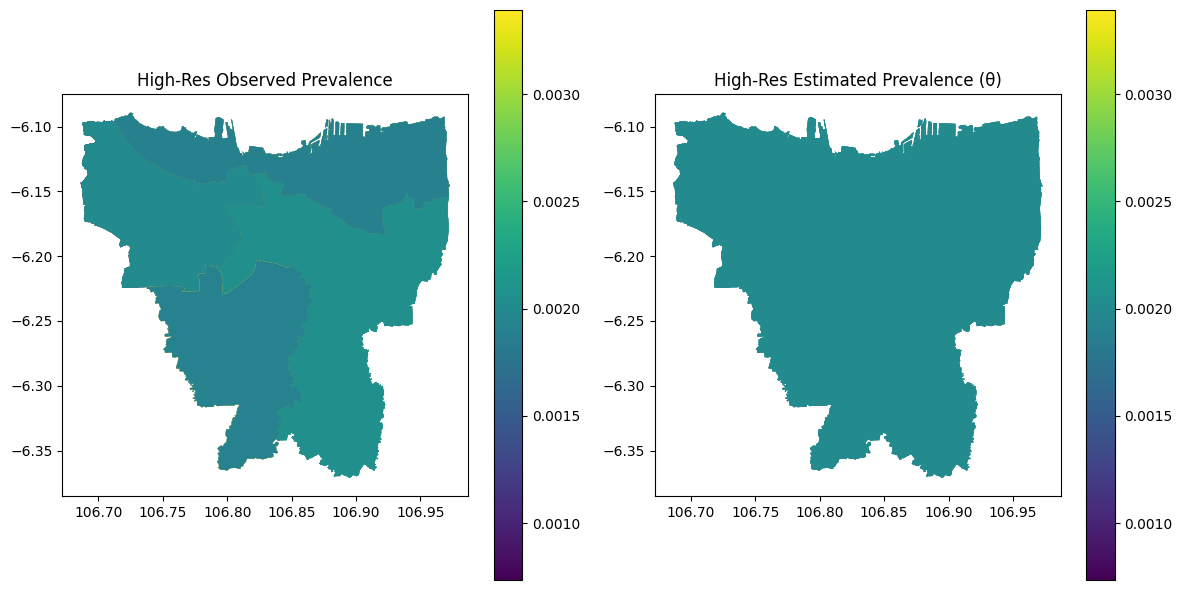

<Figure size 800x600 with 0 Axes>

In [459]:
# Create the figure and axes
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot observed prevalence on the map
df_hi.plot(
    column="obs_prev",  # Column to use for color
    cmap="viridis",  # Colormap
    vmin=min_val_hi,  # Minimum value for color scale
    vmax=max_val_hi,  # Maximum value for color scale
    legend=True,  # Show legend
    ax=ax[0],  # Plot on the first subplot
)
ax[0].set_title("High-Res Observed Prevalence")

# Plot estimated prevalence on the map
df_hi.plot(
    column="theta_gp",  # Column to use for color
    cmap="viridis",  # Colormap
    vmin=min_val_hi,  # Minimum value for color scale
    vmax=max_val_hi,  # Maximum value for color scale
    legend=True,  # Show legend
    ax=ax[1],  # Plot on the second subplot
)
ax[1].set_title("High-Res Estimated Prevalence (θ)")

# Save the plot
plt.savefig("observed_vs_estimated_prevalence_hi.png")  # Save as PNG
# Or save as PDF:
# plt.savefig("observed_vs_estimated_prevalence.pdf")

plt.tight_layout()
plt.show()

#save the plot
plt.figure(figsize=(8, 6))

plt.show()

### Plot scatterplot

In [460]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Convert JAX arrays to NumPy arrays before plotting
def plot_scatter(ax, df, bci_25, bci_75, title, color):
    theta_obs = np.asarray(df["obs_prev"])
    theta_gp_est = np.asarray(df["theta_gp"])
    bci_25 = np.asarray(bci_25)
    bci_75 = np.asarray(bci_75)

    # Compute min and max for plot limits
    _max = max(theta_obs.max(), theta_gp_est.max())
    _min = min(theta_obs.min(), theta_gp_est.min())

    # Scatter plot of observed vs estimated prevalence
    sns.scatterplot(x=theta_obs, y=theta_gp_est, label="Observed vs Estimated", color=color, ax=ax)

    # Add IQR shaded region
    ax.fill_between(theta_obs, bci_25, bci_75, color=color, alpha=0.2, label="IQR (25%-75%)")

    # Plot reference line (y = x) for comparison
    sns.lineplot(x=[_min, _max], y=[_min, _max], color="red", linestyle="--", label="y = x", ax=ax)

    ax.set_xlabel("Observed Prevalence")
    ax.set_ylabel("Estimated Prevalence (θ)")
    ax.set_title(title)
    ax.legend()

# Create scattrplot for high-res predictions vs actual values
plot_scatter( df_hi, bci_hi_25, bci_hi_75, "High-Res Observed vs Estimated Prevalence", "green")

# Adjust layout and save figure
plt.tight_layout()
plt.savefig("observed_vs_estimated_prevalence_scatter_aggGP.png")
plt.show()

TypeError: plot_scatter() missing 1 required positional argument: 'color'

In [ ]:
#save df
df_hi.to_file("../data/df_with_gp_preds_highres.shp")
df_hi.to_csv("../data/df_with_gp_preds_highres.csv")